In [1]:
# from scipy.stats import entropy
from scipy.stats.mstats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

from __init__ import *
from snmcseq_utils import create_logger
from snmcseq_utils import tsne_and_boxplot 
from CEMBA_update_mysql import connect_sql
from CEMBA_update_mysql import gene_id_to_table_name
from CEMBA_init_ensemble_v2 import pull_genebody_info 

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# import importlib
# import snmcseq_utils
# importlib.reload(snmcseq_utils)
# from snmcseq_utils import tsne_and_boxplot 


In [3]:
def get_cluster_mc_c_worker(df_cells, df_input, cluster_col):
    """reduce gene*cell or bin*cell matrix to a gene*cluster or bin*cluster matrix
    Arguments:
        - df_cells: a dataframe indexed by 'cell_name', and have '$cluster_col' as column
        - df_input: a dataframe with 'sample_mc', 'sample_c' ... as columns
        sample names are cell names
    """
    # cluster mc_c
    df_c = df_input.filter(regex='_c$')
    df_mc = df_input.filter(regex='_mc$')

    df_mc_c = pd.DataFrame() 
    for label, df_sub in df_cells.groupby(cluster_col):
        samples = df_sub.index.values
        df_mc_c['{}_mc'.format(label)] = df_mc[samples+'_mc'].sum(axis=1)
        df_mc_c['{}_c'.format(label)] = df_c[samples+'_c'].sum(axis=1)

    logging.info("Output shape: {}".format(df_mc_c.shape))
    return df_mc_c

In [4]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc


In [5]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

In [6]:
log = create_logger()

In [70]:
# set up
ens = 'Ens10'
context = 'CH'
cluster_col = 'cluster_mCHmCG_lv_npc50_k30'
cells_mc_c_file = None

ens_genelevel_path = os.path.join(PATH_ENSEMBLES, ens, 'gene_level')
engine = connect_sql(DATABASE)

In [71]:
# get gene annotation
sql = '''SELECT * FROM genes'''
df_genes = pd.read_sql(sql, engine, index_col='gene_id')

In [72]:
# get cells info
ens_path = os.path.join(PATH_ENSEMBLES, ens)
sql = """SELECT cell_name, dataset, global_m{}, {} FROM cells
        JOIN {} ON cells.cell_id = {}.cell_id""".format(context, cluster_col, ens, ens)
df_cells = pd.read_sql(sql, engine, index_col='cell_name') 


In [ ]:
### get cells_mc_c
# If not provided, get default file path
if not cells_mc_c_file:
    cells_mc_c_file = os.path.join(PATH_ENSEMBLES, ens, 'gene_level', 'genebody_mCH_{}.tsv.bgz'.format(ens))

# If the file doesn't exist, pull from datasets (takes time)
if not os.path.isfile(cells_mc_c_file):
    ### pull genebody info
    # get cells and genebody paths
    logging.info("{} doesn't exist, pulling info from datasets... (This step takes time)".format(cells_mc_c_file))
    cells = []
    genebody_paths = []
    for dataset, df_sub in df_cells.groupby('dataset'):
        cells_tmp = sorted(df_sub.index.tolist())
        paths_tmp = [os.path.join(PATH_DATASETS, dataset, 'gene_level', 'genebody_{}.tsv.bgz'.format(cell)) 
                     for cell in cells_tmp]
        cells += cells_tmp
        genebody_paths += paths_tmp
        
    pull_genebody_info(ens, ens_genelevel_path, cells, genebody_paths, 
                    contexts=CONTEXTS, to_file=True)

# read cells_mc_c files
try:
    cells_mc_c = pd.read_table(cells_mc_c_file, compression='gzip', index_col='gene_id')
    logging.info("Got cells_mc_c matrix: {}".format(cells_mc_c.shape))
except:
    raise ValueError("Unable to read file {}".format(cells_mc_c_file))
    

03/19/2018 10:17:22 AM /cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens10/gene_level/genebody_mCH_Ens10.tsv.bgz doesn't exist, pulling info from datasets... (This step takes time)
03/19/2018 10:17:22 AM Pulling genebody information (5352 cells)...
03/19/2018 10:17:22 AM /cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens10/gene_level created!
03/19/2018 10:17:22 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed (1/5352)
03/19/2018 10:17:22 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed (2/5352)
03/19/2018 10:17:22 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed (3/5352)
03/19/2018 10:17:22 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed (4/5352)
03/19/2018 10:17:22 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed (5/5352)
03/19/2018 10:17

03/19/2018 10:17:29 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A7_AD010_indexed (63/5352)
03/19/2018 10:17:29 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A7_AD012_indexed (64/5352)
03/19/2018 10:17:29 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A8_AD001_indexed (65/5352)
03/19/2018 10:17:29 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A8_AD004_indexed (66/5352)
03/19/2018 10:17:29 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A8_AD006_indexed (67/5352)
03/19/2018 10:17:29 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A8_AD007_indexed (68/5352)
03/19/2018 10:17:29 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A8_AD008_indexed (69/5352)
03/19/2018 10:17:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A8_

03/19/2018 10:17:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_B4_AD010_indexed (127/5352)
03/19/2018 10:17:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_B5_AD001_indexed (128/5352)
03/19/2018 10:17:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_B5_AD002_indexed (129/5352)
03/19/2018 10:17:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_B5_AD004_indexed (130/5352)
03/19/2018 10:17:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_B5_AD006_indexed (131/5352)
03/19/2018 10:17:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_B5_AD007_indexed (132/5352)
03/19/2018 10:17:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_B5_AD010_indexed (133/5352)
03/19/2018 10:17:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3

03/19/2018 10:17:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C1_AD010_indexed (191/5352)
03/19/2018 10:17:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C1_AD012_indexed (192/5352)
03/19/2018 10:17:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C2_AD001_indexed (193/5352)
03/19/2018 10:17:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C2_AD002_indexed (194/5352)
03/19/2018 10:17:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C2_AD004_indexed (195/5352)
03/19/2018 10:17:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C2_AD006_indexed (196/5352)
03/19/2018 10:17:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C2_AD007_indexed (197/5352)
03/19/2018 10:17:45 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3

03/19/2018 10:17:52 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D11_AD007_indexed (255/5352)
03/19/2018 10:17:52 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D11_AD008_indexed (256/5352)
03/19/2018 10:17:52 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D12_AD001_indexed (257/5352)
03/19/2018 10:17:52 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D12_AD002_indexed (258/5352)
03/19/2018 10:17:52 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D12_AD006_indexed (259/5352)
03/19/2018 10:17:52 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D12_AD007_indexed (260/5352)
03/19/2018 10:17:53 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D12_AD008_indexed (261/5352)
03/19/2018 10:17:53 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA1

03/19/2018 10:18:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D8_AD007_indexed (319/5352)
03/19/2018 10:18:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D8_AD008_indexed (320/5352)
03/19/2018 10:18:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D8_AD010_indexed (321/5352)
03/19/2018 10:18:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D8_AD012_indexed (322/5352)
03/19/2018 10:18:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D9_AD001_indexed (323/5352)
03/19/2018 10:18:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D9_AD002_indexed (324/5352)
03/19/2018 10:18:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_D9_AD004_indexed (325/5352)
03/19/2018 10:18:01 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3

03/19/2018 10:18:07 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E6_AD002_indexed (383/5352)
03/19/2018 10:18:08 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E6_AD004_indexed (384/5352)
03/19/2018 10:18:08 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E6_AD007_indexed (385/5352)
03/19/2018 10:18:08 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E6_AD008_indexed (386/5352)
03/19/2018 10:18:08 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E6_AD010_indexed (387/5352)
03/19/2018 10:18:08 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E6_AD012_indexed (388/5352)
03/19/2018 10:18:08 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E7_AD001_indexed (389/5352)
03/19/2018 10:18:08 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3

03/19/2018 10:18:15 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_F3_AD012_indexed (447/5352)
03/19/2018 10:18:16 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_F4_AD001_indexed (448/5352)
03/19/2018 10:18:16 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_F4_AD002_indexed (449/5352)
03/19/2018 10:18:16 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_F4_AD006_indexed (450/5352)
03/19/2018 10:18:18 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_F4_AD007_indexed (451/5352)
03/19/2018 10:18:19 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_F4_AD008_indexed (452/5352)
03/19/2018 10:18:19 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_F4_AD010_indexed (453/5352)
03/19/2018 10:18:19 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3

03/19/2018 10:18:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G2_AD002_indexed (511/5352)
03/19/2018 10:18:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G2_AD004_indexed (512/5352)
03/19/2018 10:18:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G2_AD006_indexed (513/5352)
03/19/2018 10:18:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G2_AD007_indexed (514/5352)
03/19/2018 10:18:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G2_AD008_indexed (515/5352)
03/19/2018 10:18:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD001_indexed (516/5352)
03/19/2018 10:18:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD002_indexed (517/5352)
03/19/2018 10:18:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3

03/19/2018 10:18:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H12_AD007_indexed (575/5352)
03/19/2018 10:18:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H12_AD008_indexed (576/5352)
03/19/2018 10:18:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H12_AD010_indexed (577/5352)
03/19/2018 10:18:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H12_AD012_indexed (578/5352)
03/19/2018 10:18:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H1_AD001_indexed (579/5352)
03/19/2018 10:18:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H1_AD002_indexed (580/5352)
03/19/2018 10:18:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H1_AD004_indexed (581/5352)
03/19/2018 10:18:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA1712

03/19/2018 10:18:47 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A10_AD012_indexed (639/5352)
03/19/2018 10:18:47 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD001_indexed (640/5352)
03/19/2018 10:18:47 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed (641/5352)
03/19/2018 10:18:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD004_indexed (642/5352)
03/19/2018 10:18:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD006_indexed (643/5352)
03/19/2018 10:18:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD007_indexed (644/5352)
03/19/2018 10:18:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD008_indexed (645/5352)
03/19/2018 10:18:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA1

03/19/2018 10:19:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A7_AD012_indexed (703/5352)
03/19/2018 10:19:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A8_AD002_indexed (704/5352)
03/19/2018 10:19:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A8_AD004_indexed (705/5352)
03/19/2018 10:19:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A8_AD006_indexed (706/5352)
03/19/2018 10:19:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A8_AD010_indexed (707/5352)
03/19/2018 10:19:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A8_AD012_indexed (708/5352)
03/19/2018 10:19:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A9_AD001_indexed (709/5352)
03/19/2018 10:19:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3

03/19/2018 10:19:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B4_AD007_indexed (767/5352)
03/19/2018 10:19:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B4_AD008_indexed (768/5352)
03/19/2018 10:19:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B4_AD010_indexed (769/5352)
03/19/2018 10:19:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B4_AD012_indexed (770/5352)
03/19/2018 10:19:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B5_AD001_indexed (771/5352)
03/19/2018 10:19:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B5_AD002_indexed (772/5352)
03/19/2018 10:19:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B5_AD004_indexed (773/5352)
03/19/2018 10:19:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3

03/19/2018 10:19:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C1_AD007_indexed (831/5352)
03/19/2018 10:19:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C1_AD008_indexed (832/5352)
03/19/2018 10:19:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C1_AD010_indexed (833/5352)
03/19/2018 10:19:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C2_AD001_indexed (834/5352)
03/19/2018 10:19:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C2_AD004_indexed (835/5352)
03/19/2018 10:19:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C2_AD007_indexed (836/5352)
03/19/2018 10:19:27 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C2_AD008_indexed (837/5352)
03/19/2018 10:19:28 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3

03/19/2018 10:19:39 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D11_AD006_indexed (895/5352)
03/19/2018 10:19:39 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D11_AD007_indexed (896/5352)
03/19/2018 10:19:39 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D11_AD008_indexed (897/5352)
03/19/2018 10:19:39 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D11_AD010_indexed (898/5352)
03/19/2018 10:19:39 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D11_AD012_indexed (899/5352)
03/19/2018 10:19:40 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D12_AD002_indexed (900/5352)
03/19/2018 10:19:45 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D12_AD004_indexed (901/5352)
03/19/2018 10:19:46 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA1

03/19/2018 10:19:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D8_AD004_indexed (959/5352)
03/19/2018 10:19:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D8_AD006_indexed (960/5352)
03/19/2018 10:19:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D8_AD007_indexed (961/5352)
03/19/2018 10:19:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D8_AD008_indexed (962/5352)
03/19/2018 10:19:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D8_AD010_indexed (963/5352)
03/19/2018 10:19:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D8_AD012_indexed (964/5352)
03/19/2018 10:19:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_D9_AD001_indexed (965/5352)
03/19/2018 10:20:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3

03/19/2018 10:20:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_E5_AD006_indexed (1023/5352)
03/19/2018 10:20:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_E5_AD007_indexed (1024/5352)
03/19/2018 10:20:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_E5_AD008_indexed (1025/5352)
03/19/2018 10:20:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_E5_AD010_indexed (1026/5352)
03/19/2018 10:20:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_E5_AD012_indexed (1027/5352)
03/19/2018 10:20:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_E6_AD001_indexed (1028/5352)
03/19/2018 10:20:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_E6_AD002_indexed (1029/5352)
03/19/2018 10:20:12 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA1

03/19/2018 10:20:25 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_F2_AD012_indexed (1086/5352)
03/19/2018 10:20:25 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_F3_AD002_indexed (1087/5352)
03/19/2018 10:20:25 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_F3_AD004_indexed (1088/5352)
03/19/2018 10:20:25 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_F3_AD006_indexed (1089/5352)
03/19/2018 10:20:25 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_F3_AD007_indexed (1090/5352)
03/19/2018 10:20:26 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_F3_AD008_indexed (1091/5352)
03/19/2018 10:20:26 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_F3_AD010_indexed (1092/5352)
03/19/2018 10:20:26 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA1

03/19/2018 10:20:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_G3_AD010_indexed (1149/5352)
03/19/2018 10:20:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_G3_AD012_indexed (1150/5352)
03/19/2018 10:20:49 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_G4_AD001_indexed (1151/5352)
03/19/2018 10:20:49 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_G4_AD007_indexed (1152/5352)
03/19/2018 10:20:49 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_G4_AD008_indexed (1153/5352)
03/19/2018 10:20:49 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_G4_AD010_indexed (1154/5352)
03/19/2018 10:20:49 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_G4_AD012_indexed (1155/5352)
03/19/2018 10:20:49 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA1

03/19/2018 10:21:05 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A11_AD002_indexed (1212/5352)
03/19/2018 10:21:05 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A11_AD004_indexed (1213/5352)
03/19/2018 10:21:05 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A11_AD007_indexed (1214/5352)
03/19/2018 10:21:05 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A11_AD010_indexed (1215/5352)
03/19/2018 10:21:05 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A11_AD012_indexed (1216/5352)
03/19/2018 10:21:05 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A12_AD004_indexed (1217/5352)
03/19/2018 10:21:06 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A12_AD006_indexed (1218/5352)
03/19/2018 10:21:06 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1

03/19/2018 10:21:21 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B10_AD010_indexed (1275/5352)
03/19/2018 10:21:21 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B10_AD012_indexed (1276/5352)
03/19/2018 10:21:21 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B11_AD001_indexed (1277/5352)
03/19/2018 10:21:21 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B11_AD002_indexed (1278/5352)
03/19/2018 10:21:21 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B11_AD004_indexed (1279/5352)
03/19/2018 10:21:22 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B11_AD006_indexed (1280/5352)
03/19/2018 10:21:22 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B11_AD007_indexed (1281/5352)
03/19/2018 10:21:22 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1

03/19/2018 10:21:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B9_AD006_indexed (1338/5352)
03/19/2018 10:21:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B9_AD007_indexed (1339/5352)
03/19/2018 10:21:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B9_AD008_indexed (1340/5352)
03/19/2018 10:21:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B9_AD010_indexed (1341/5352)
03/19/2018 10:21:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_B9_AD012_indexed (1342/5352)
03/19/2018 10:21:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C10_AD001_indexed (1343/5352)
03/19/2018 10:21:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C10_AD002_indexed (1344/5352)
03/19/2018 10:21:37 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMB

03/19/2018 10:22:01 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C7_AD004_indexed (1401/5352)
03/19/2018 10:22:01 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C7_AD006_indexed (1402/5352)
03/19/2018 10:22:02 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C7_AD007_indexed (1403/5352)
03/19/2018 10:22:02 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C7_AD008_indexed (1404/5352)
03/19/2018 10:22:02 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C7_AD010_indexed (1405/5352)
03/19/2018 10:22:02 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C7_AD012_indexed (1406/5352)
03/19/2018 10:22:02 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_C8_AD001_indexed (1407/5352)
03/19/2018 10:22:02 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA1

03/19/2018 10:22:16 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D4_AD008_indexed (1464/5352)
03/19/2018 10:22:16 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D4_AD010_indexed (1465/5352)
03/19/2018 10:22:16 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D4_AD012_indexed (1466/5352)
03/19/2018 10:22:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D5_AD001_indexed (1467/5352)
03/19/2018 10:22:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D5_AD002_indexed (1468/5352)
03/19/2018 10:22:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D5_AD006_indexed (1469/5352)
03/19/2018 10:22:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D5_AD007_indexed (1470/5352)
03/19/2018 10:22:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA1

03/19/2018 10:22:43 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_E2_AD002_indexed (1527/5352)
03/19/2018 10:22:43 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_E2_AD004_indexed (1528/5352)
03/19/2018 10:22:43 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_E2_AD006_indexed (1529/5352)
03/19/2018 10:22:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_E2_AD007_indexed (1530/5352)
03/19/2018 10:22:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_E2_AD008_indexed (1531/5352)
03/19/2018 10:22:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_E2_AD010_indexed (1532/5352)
03/19/2018 10:22:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_E2_AD012_indexed (1533/5352)
03/19/2018 10:22:44 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA1

03/19/2018 10:22:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F10_AD007_indexed (1590/5352)
03/19/2018 10:22:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F10_AD008_indexed (1591/5352)
03/19/2018 10:22:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F10_AD010_indexed (1592/5352)
03/19/2018 10:23:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F10_AD012_indexed (1593/5352)
03/19/2018 10:23:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F11_AD001_indexed (1594/5352)
03/19/2018 10:23:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F11_AD002_indexed (1595/5352)
03/19/2018 10:23:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F11_AD004_indexed (1596/5352)
03/19/2018 10:23:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1

03/19/2018 10:23:51 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F7_AD002_indexed (1653/5352)
03/19/2018 10:23:51 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F7_AD004_indexed (1654/5352)
03/19/2018 10:23:51 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F7_AD007_indexed (1655/5352)
03/19/2018 10:23:51 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F7_AD008_indexed (1656/5352)
03/19/2018 10:23:51 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F7_AD012_indexed (1657/5352)
03/19/2018 10:23:51 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F8_AD001_indexed (1658/5352)
03/19/2018 10:23:52 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_F8_AD002_indexed (1659/5352)
03/19/2018 10:23:52 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA1

03/19/2018 10:24:16 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_G4_AD012_indexed (1716/5352)
03/19/2018 10:24:16 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_G5_AD001_indexed (1717/5352)
03/19/2018 10:24:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_G5_AD004_indexed (1718/5352)
03/19/2018 10:24:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_G5_AD006_indexed (1719/5352)
03/19/2018 10:24:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_G5_AD007_indexed (1720/5352)
03/19/2018 10:24:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_G5_AD008_indexed (1721/5352)
03/19/2018 10:24:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_G5_AD010_indexed (1722/5352)
03/19/2018 10:24:17 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA1

03/19/2018 10:24:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_H2_AD006_indexed (1779/5352)
03/19/2018 10:24:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_H2_AD007_indexed (1780/5352)
03/19/2018 10:24:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_H2_AD008_indexed (1781/5352)
03/19/2018 10:24:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_H2_AD010_indexed (1782/5352)
03/19/2018 10:24:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_H2_AD012_indexed (1783/5352)
03/19/2018 10:24:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_H3_AD001_indexed (1784/5352)
03/19/2018 10:24:41 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_H3_AD002_indexed (1785/5352)
03/19/2018 10:24:42 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA1

03/19/2018 10:25:03 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A11_AD012_indexed (1842/5352)
03/19/2018 10:25:03 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A12_AD002_indexed (1843/5352)
03/19/2018 10:25:03 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A12_AD006_indexed (1844/5352)
03/19/2018 10:25:03 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A12_AD008_indexed (1845/5352)
03/19/2018 10:25:03 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A1_AD001_indexed (1846/5352)
03/19/2018 10:25:03 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A1_AD002_indexed (1847/5352)
03/19/2018 10:25:03 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A1_AD004_indexed (1848/5352)
03/19/2018 10:25:04 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CE

03/19/2018 10:25:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD001_indexed (1905/5352)
03/19/2018 10:25:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD002_indexed (1906/5352)
03/19/2018 10:25:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD004_indexed (1907/5352)
03/19/2018 10:25:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD006_indexed (1908/5352)
03/19/2018 10:25:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD007_indexed (1909/5352)
03/19/2018 10:25:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD008_indexed (1910/5352)
03/19/2018 10:25:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD012_indexed (1911/5352)
03/19/2018 10:25:36 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3

03/19/2018 10:25:53 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B6_AD008_indexed (1968/5352)
03/19/2018 10:25:53 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B6_AD010_indexed (1969/5352)
03/19/2018 10:25:53 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B6_AD012_indexed (1970/5352)
03/19/2018 10:25:54 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B7_AD001_indexed (1971/5352)
03/19/2018 10:25:54 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B7_AD002_indexed (1972/5352)
03/19/2018 10:25:54 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B7_AD004_indexed (1973/5352)
03/19/2018 10:25:54 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B7_AD006_indexed (1974/5352)
03/19/2018 10:25:54 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA1

03/19/2018 10:26:10 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_C3_AD004_indexed (2031/5352)
03/19/2018 10:26:10 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_C3_AD006_indexed (2032/5352)
03/19/2018 10:26:10 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_C3_AD007_indexed (2033/5352)
03/19/2018 10:26:10 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_C3_AD008_indexed (2034/5352)
03/19/2018 10:26:10 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_C3_AD010_indexed (2035/5352)
03/19/2018 10:26:10 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_C3_AD012_indexed (2036/5352)
03/19/2018 10:26:10 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_C4_AD004_indexed (2037/5352)
03/19/2018 10:26:10 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA1

03/19/2018 10:26:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_D12_AD012_indexed (2094/5352)
03/19/2018 10:26:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_D1_AD001_indexed (2095/5352)
03/19/2018 10:26:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_D1_AD002_indexed (2096/5352)
03/19/2018 10:26:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_D1_AD004_indexed (2097/5352)
03/19/2018 10:26:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_D1_AD006_indexed (2098/5352)
03/19/2018 10:26:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_D1_AD008_indexed (2099/5352)
03/19/2018 10:26:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_D1_AD010_indexed (2100/5352)
03/19/2018 10:26:51 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA

03/19/2018 10:27:14 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E10_AD004_indexed (2158/5352)
03/19/2018 10:27:14 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E10_AD006_indexed (2159/5352)
03/19/2018 10:27:14 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E10_AD007_indexed (2160/5352)
03/19/2018 10:27:14 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E10_AD008_indexed (2161/5352)
03/19/2018 10:27:14 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E10_AD010_indexed (2162/5352)
03/19/2018 10:27:14 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E10_AD012_indexed (2163/5352)
03/19/2018 10:27:14 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E11_AD001_indexed (2164/5352)
03/19/2018 10:27:14 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3

03/19/2018 10:27:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E7_AD004_indexed (2221/5352)
03/19/2018 10:27:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E7_AD006_indexed (2222/5352)
03/19/2018 10:27:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E7_AD007_indexed (2223/5352)
03/19/2018 10:27:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E7_AD012_indexed (2224/5352)
03/19/2018 10:27:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E8_AD002_indexed (2225/5352)
03/19/2018 10:27:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E8_AD004_indexed (2226/5352)
03/19/2018 10:27:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_E8_AD006_indexed (2227/5352)
03/19/2018 10:27:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA1

03/19/2018 10:27:47 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F5_AD002_indexed (2284/5352)
03/19/2018 10:27:47 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F5_AD004_indexed (2285/5352)
03/19/2018 10:27:47 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F5_AD006_indexed (2286/5352)
03/19/2018 10:27:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F5_AD007_indexed (2287/5352)
03/19/2018 10:27:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F5_AD008_indexed (2288/5352)
03/19/2018 10:27:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F5_AD010_indexed (2289/5352)
03/19/2018 10:27:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F5_AD012_indexed (2290/5352)
03/19/2018 10:27:48 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA1

03/19/2018 10:28:06 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_G1_AD012_indexed (2347/5352)
03/19/2018 10:28:06 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_G2_AD001_indexed (2348/5352)
03/19/2018 10:28:06 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_G2_AD002_indexed (2349/5352)
03/19/2018 10:28:06 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_G2_AD004_indexed (2350/5352)
03/19/2018 10:28:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_G2_AD006_indexed (2351/5352)
03/19/2018 10:28:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_G2_AD007_indexed (2352/5352)
03/19/2018 10:28:30 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_G2_AD008_indexed (2353/5352)
03/19/2018 10:28:31 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA1

03/19/2018 10:28:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H10_AD007_indexed (2410/5352)
03/19/2018 10:28:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H10_AD008_indexed (2411/5352)
03/19/2018 10:28:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H10_AD010_indexed (2412/5352)
03/19/2018 10:28:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H10_AD012_indexed (2413/5352)
03/19/2018 10:28:59 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H11_AD001_indexed (2414/5352)
03/19/2018 10:29:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H11_AD002_indexed (2415/5352)
03/19/2018 10:29:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H11_AD004_indexed (2416/5352)
03/19/2018 10:29:00 AM Loaded cell: 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3

03/19/2018 10:29:38 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_A10_AD001_indexed (2473/5352)
03/19/2018 10:29:38 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_A10_AD012_indexed (2474/5352)
03/19/2018 10:29:38 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_A12_AD001_indexed (2475/5352)
03/19/2018 10:29:38 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_A12_AD006_indexed (2476/5352)
03/19/2018 10:29:39 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_A1_AD002_indexed (2477/5352)
03/19/2018 10:29:39 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_A1_AD010_indexed (2478/5352)
03/19/2018 10:29:39 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_A2_AD002_indexed (2479/5352)
03/19/2018 10:29:39 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_A2_AD010_indexed 

03/19/2018 10:30:08 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_B7_AD012_indexed (2538/5352)
03/19/2018 10:30:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_B8_AD012_indexed (2539/5352)
03/19/2018 10:30:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_B9_AD004_indexed (2540/5352)
03/19/2018 10:30:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_B9_AD007_indexed (2541/5352)
03/19/2018 10:30:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_B9_AD008_indexed (2542/5352)
03/19/2018 10:30:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_B9_AD010_indexed (2543/5352)
03/19/2018 10:30:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_C10_AD001_indexed (2544/5352)
03/19/2018 10:30:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_C10_AD002_indexed (2

03/19/2018 10:30:55 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_E12_AD001_indexed (2603/5352)
03/19/2018 10:30:55 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_E12_AD007_indexed (2604/5352)
03/19/2018 10:30:55 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_E1_AD001_indexed (2605/5352)
03/19/2018 10:30:56 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_E1_AD006_indexed (2606/5352)
03/19/2018 10:30:56 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_E1_AD010_indexed (2607/5352)
03/19/2018 10:30:56 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_E2_AD001_indexed (2608/5352)
03/19/2018 10:30:56 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_E3_AD002_indexed (2609/5352)
03/19/2018 10:30:56 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_1_CEMBA171212_4B_2_E3_AD006_indexed (2

03/19/2018 10:31:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_A2_AD006_indexed (2668/5352)
03/19/2018 10:31:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_A3_AD001_indexed (2669/5352)
03/19/2018 10:31:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_A5_AD004_indexed (2670/5352)
03/19/2018 10:31:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_A5_AD010_indexed (2671/5352)
03/19/2018 10:31:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_A7_AD004_indexed (2672/5352)
03/19/2018 10:31:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_A7_AD012_indexed (2673/5352)
03/19/2018 10:31:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_A9_AD008_indexed (2674/5352)
03/19/2018 10:31:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_A9_AD012_indexed (267

03/19/2018 10:32:17 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_D8_AD010_indexed (2733/5352)
03/19/2018 10:32:17 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_D9_AD008_indexed (2734/5352)
03/19/2018 10:32:18 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_D9_AD010_indexed (2735/5352)
03/19/2018 10:32:18 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_E10_AD008_indexed (2736/5352)
03/19/2018 10:32:18 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_E12_AD010_indexed (2737/5352)
03/19/2018 10:32:18 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_E1_AD010_indexed (2738/5352)
03/19/2018 10:32:18 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_E2_AD010_indexed (2739/5352)
03/19/2018 10:32:18 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171212_4B_3_CEMBA171212_4B_4_E2_AD012_indexed (2

03/19/2018 10:32:48 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_A3_AD004_indexed (2798/5352)
03/19/2018 10:32:48 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_A3_AD006_indexed (2799/5352)
03/19/2018 10:32:48 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_A3_AD007_indexed (2800/5352)
03/19/2018 10:33:07 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_A3_AD008_indexed (2801/5352)
03/19/2018 10:33:07 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_A3_AD010_indexed (2802/5352)
03/19/2018 10:33:08 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_A3_AD012_indexed (2803/5352)
03/19/2018 10:33:08 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_A4_AD001_indexed (2804/5352)
03/19/2018 10:33:08 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_A4_AD002_indexed (280

03/19/2018 10:33:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_B1_AD006_indexed (2863/5352)
03/19/2018 10:33:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_B1_AD007_indexed (2864/5352)
03/19/2018 10:33:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_B1_AD008_indexed (2865/5352)
03/19/2018 10:33:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_B1_AD010_indexed (2866/5352)
03/19/2018 10:33:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_B1_AD012_indexed (2867/5352)
03/19/2018 10:33:28 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_B2_AD001_indexed (2868/5352)
03/19/2018 10:33:29 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_B2_AD002_indexed (2869/5352)
03/19/2018 10:33:29 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_B2_AD004_indexed (287

03/19/2018 10:33:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C10_AD001_indexed (2929/5352)
03/19/2018 10:33:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C10_AD002_indexed (2930/5352)
03/19/2018 10:33:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C10_AD004_indexed (2931/5352)
03/19/2018 10:33:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C10_AD006_indexed (2932/5352)
03/19/2018 10:33:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C10_AD007_indexed (2933/5352)
03/19/2018 10:33:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C10_AD008_indexed (2934/5352)
03/19/2018 10:33:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C10_AD010_indexed (2935/5352)
03/19/2018 10:33:48 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C10_AD012_inde

03/19/2018 10:34:10 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C8_AD001_indexed (2994/5352)
03/19/2018 10:34:11 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C8_AD002_indexed (2995/5352)
03/19/2018 10:34:11 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C8_AD004_indexed (2996/5352)
03/19/2018 10:34:11 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C8_AD006_indexed (2997/5352)
03/19/2018 10:34:11 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C8_AD007_indexed (2998/5352)
03/19/2018 10:34:11 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C8_AD008_indexed (2999/5352)
03/19/2018 10:34:11 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C8_AD010_indexed (3000/5352)
03/19/2018 10:34:25 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_C8_AD012_indexed (300

03/19/2018 10:34:43 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_D5_AD008_indexed (3059/5352)
03/19/2018 10:34:43 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_D5_AD010_indexed (3060/5352)
03/19/2018 10:34:43 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_D5_AD012_indexed (3061/5352)
03/19/2018 10:34:43 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_D6_AD001_indexed (3062/5352)
03/19/2018 10:34:43 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_D6_AD002_indexed (3063/5352)
03/19/2018 10:34:44 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_D6_AD004_indexed (3064/5352)
03/19/2018 10:34:44 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_D6_AD006_indexed (3065/5352)
03/19/2018 10:34:44 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_D6_AD007_indexed (306

03/19/2018 10:34:59 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_E4_AD001_indexed (3124/5352)
03/19/2018 10:34:59 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_E4_AD002_indexed (3125/5352)
03/19/2018 10:34:59 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_E4_AD004_indexed (3126/5352)
03/19/2018 10:34:59 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_E4_AD006_indexed (3127/5352)
03/19/2018 10:35:00 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_E4_AD007_indexed (3128/5352)
03/19/2018 10:35:00 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_E4_AD008_indexed (3129/5352)
03/19/2018 10:35:00 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_E4_AD010_indexed (3130/5352)
03/19/2018 10:35:00 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_E4_AD012_indexed (313

03/19/2018 10:35:20 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_F1_AD010_indexed (3189/5352)
03/19/2018 10:35:20 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_F1_AD012_indexed (3190/5352)
03/19/2018 10:35:21 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_F2_AD001_indexed (3191/5352)
03/19/2018 10:35:21 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_F2_AD002_indexed (3192/5352)
03/19/2018 10:35:21 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_F2_AD004_indexed (3193/5352)
03/19/2018 10:35:21 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_F2_AD006_indexed (3194/5352)
03/19/2018 10:35:21 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_F2_AD007_indexed (3195/5352)
03/19/2018 10:35:21 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_F2_AD008_indexed (319

03/19/2018 10:35:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G10_AD006_indexed (3254/5352)
03/19/2018 10:35:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G10_AD007_indexed (3255/5352)
03/19/2018 10:35:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G10_AD008_indexed (3256/5352)
03/19/2018 10:35:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G10_AD010_indexed (3257/5352)
03/19/2018 10:35:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G10_AD012_indexed (3258/5352)
03/19/2018 10:35:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G12_AD006_indexed (3259/5352)
03/19/2018 10:35:55 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G12_AD007_indexed (3260/5352)
03/19/2018 10:35:55 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G12_AD010_inde

03/19/2018 10:36:37 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G8_AD010_indexed (3319/5352)
03/19/2018 10:36:37 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G8_AD012_indexed (3320/5352)
03/19/2018 10:36:37 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G9_AD001_indexed (3321/5352)
03/19/2018 10:36:38 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G9_AD002_indexed (3322/5352)
03/19/2018 10:36:38 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G9_AD004_indexed (3323/5352)
03/19/2018 10:36:38 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G9_AD006_indexed (3324/5352)
03/19/2018 10:36:39 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G9_AD007_indexed (3325/5352)
03/19/2018 10:36:39 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_G9_AD008_indexed (332

03/19/2018 10:37:22 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_H6_AD012_indexed (3384/5352)
03/19/2018 10:37:22 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_H7_AD001_indexed (3385/5352)
03/19/2018 10:37:22 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_H7_AD002_indexed (3386/5352)
03/19/2018 10:37:22 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_H7_AD004_indexed (3387/5352)
03/19/2018 10:37:23 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_H7_AD006_indexed (3388/5352)
03/19/2018 10:37:23 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_H7_AD007_indexed (3389/5352)
03/19/2018 10:37:23 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_H7_AD008_indexed (3390/5352)
03/19/2018 10:37:23 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_1_CEMBA171213_4B_2_H7_AD010_indexed (339

03/19/2018 10:38:06 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_A4_AD007_indexed (3449/5352)
03/19/2018 10:38:06 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_A4_AD010_indexed (3450/5352)
03/19/2018 10:38:39 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_A4_AD012_indexed (3451/5352)
03/19/2018 10:38:40 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_A5_AD001_indexed (3452/5352)
03/19/2018 10:38:40 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_A5_AD004_indexed (3453/5352)
03/19/2018 10:38:40 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_A5_AD007_indexed (3454/5352)
03/19/2018 10:38:41 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_A5_AD008_indexed (3455/5352)
03/19/2018 10:38:41 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_A5_AD010_indexed (345

03/19/2018 10:39:26 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_B2_AD010_indexed (3514/5352)
03/19/2018 10:39:26 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_B2_AD012_indexed (3515/5352)
03/19/2018 10:39:26 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_B3_AD001_indexed (3516/5352)
03/19/2018 10:39:27 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_B3_AD002_indexed (3517/5352)
03/19/2018 10:39:27 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_B3_AD004_indexed (3518/5352)
03/19/2018 10:39:27 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_B3_AD006_indexed (3519/5352)
03/19/2018 10:39:27 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_B3_AD007_indexed (3520/5352)
03/19/2018 10:39:27 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_B3_AD008_indexed (352

03/19/2018 10:40:01 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C11_AD012_indexed (3579/5352)
03/19/2018 10:40:01 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C12_AD001_indexed (3580/5352)
03/19/2018 10:40:01 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C12_AD004_indexed (3581/5352)
03/19/2018 10:40:01 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C12_AD006_indexed (3582/5352)
03/19/2018 10:40:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C12_AD007_indexed (3583/5352)
03/19/2018 10:40:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C1_AD001_indexed (3584/5352)
03/19/2018 10:40:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C1_AD002_indexed (3585/5352)
03/19/2018 10:40:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C1_AD004_indexed

03/19/2018 10:40:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C9_AD004_indexed (3644/5352)
03/19/2018 10:40:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C9_AD006_indexed (3645/5352)
03/19/2018 10:40:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C9_AD007_indexed (3646/5352)
03/19/2018 10:40:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C9_AD008_indexed (3647/5352)
03/19/2018 10:40:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C9_AD010_indexed (3648/5352)
03/19/2018 10:40:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_C9_AD012_indexed (3649/5352)
03/19/2018 10:40:55 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D10_AD001_indexed (3650/5352)
03/19/2018 10:41:21 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D10_AD002_indexed (3

03/19/2018 10:41:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D7_AD004_indexed (3709/5352)
03/19/2018 10:41:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D7_AD006_indexed (3710/5352)
03/19/2018 10:41:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D7_AD007_indexed (3711/5352)
03/19/2018 10:41:53 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D7_AD008_indexed (3712/5352)
03/19/2018 10:41:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D7_AD010_indexed (3713/5352)
03/19/2018 10:41:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D7_AD012_indexed (3714/5352)
03/19/2018 10:41:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D8_AD001_indexed (3715/5352)
03/19/2018 10:41:54 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_D8_AD002_indexed (371

03/19/2018 10:42:29 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_E6_AD001_indexed (3774/5352)
03/19/2018 10:42:29 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_E6_AD002_indexed (3775/5352)
03/19/2018 10:42:29 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_E6_AD004_indexed (3776/5352)
03/19/2018 10:42:29 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_E6_AD006_indexed (3777/5352)
03/19/2018 10:42:29 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_E6_AD007_indexed (3778/5352)
03/19/2018 10:42:30 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_E6_AD010_indexed (3779/5352)
03/19/2018 10:42:30 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_E6_AD012_indexed (3780/5352)
03/19/2018 10:42:30 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_E7_AD001_indexed (378

03/19/2018 10:43:01 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_F4_AD002_indexed (3839/5352)
03/19/2018 10:43:01 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_F4_AD004_indexed (3840/5352)
03/19/2018 10:43:01 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_F4_AD006_indexed (3841/5352)
03/19/2018 10:43:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_F4_AD007_indexed (3842/5352)
03/19/2018 10:43:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_F4_AD008_indexed (3843/5352)
03/19/2018 10:43:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_F4_AD010_indexed (3844/5352)
03/19/2018 10:43:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_F4_AD012_indexed (3845/5352)
03/19/2018 10:43:02 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_F5_AD001_indexed (384

03/19/2018 10:44:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_G2_AD012_indexed (3904/5352)
03/19/2018 10:44:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_G3_AD001_indexed (3905/5352)
03/19/2018 10:44:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_G3_AD002_indexed (3906/5352)
03/19/2018 10:44:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_G3_AD004_indexed (3907/5352)
03/19/2018 10:44:09 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_G3_AD006_indexed (3908/5352)
03/19/2018 10:44:10 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_G3_AD007_indexed (3909/5352)
03/19/2018 10:44:10 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_G3_AD008_indexed (3910/5352)
03/19/2018 10:44:10 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_G3_AD010_indexed (391

03/19/2018 10:44:46 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_H1_AD001_indexed (3969/5352)
03/19/2018 10:44:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_H1_AD002_indexed (3970/5352)
03/19/2018 10:44:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_H1_AD004_indexed (3971/5352)
03/19/2018 10:44:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_H1_AD006_indexed (3972/5352)
03/19/2018 10:44:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_H1_AD007_indexed (3973/5352)
03/19/2018 10:44:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_H1_AD008_indexed (3974/5352)
03/19/2018 10:44:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_H1_AD010_indexed (3975/5352)
03/19/2018 10:44:47 AM Loaded cell: 171219_CEMBA_mm_P56_P63_4B_CEMBA171213_4B_3_CEMBA171213_4B_4_H1_AD012_indexed (397

03/19/2018 10:45:25 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A10_AD007_indexed (4034/5352)
03/19/2018 10:45:25 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A10_AD008_indexed (4035/5352)
03/19/2018 10:45:25 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A10_AD010_indexed (4036/5352)
03/19/2018 10:45:26 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A10_AD012_indexed (4037/5352)
03/19/2018 10:45:26 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A11_AD001_indexed (4038/5352)
03/19/2018 10:45:26 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A11_AD004_indexed (4039/5352)
03/19/2018 10:45:26 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A11_AD006_indexed (4040/5352)
03/19/2018 10:45:26 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A11_AD007_inde

03/19/2018 10:45:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A7_AD006_indexed (4099/5352)
03/19/2018 10:45:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A7_AD007_indexed (4100/5352)
03/19/2018 10:46:19 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A7_AD008_indexed (4101/5352)
03/19/2018 10:46:19 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A7_AD010_indexed (4102/5352)
03/19/2018 10:46:19 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A7_AD012_indexed (4103/5352)
03/19/2018 10:46:20 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A8_AD001_indexed (4104/5352)
03/19/2018 10:46:20 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A8_AD002_indexed (4105/5352)
03/19/2018 10:46:20 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_A8_AD004_indexed (410

03/19/2018 10:46:42 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_B4_AD006_indexed (4164/5352)
03/19/2018 10:46:42 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_B4_AD007_indexed (4165/5352)
03/19/2018 10:46:42 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_B4_AD008_indexed (4166/5352)
03/19/2018 10:46:42 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_B4_AD010_indexed (4167/5352)
03/19/2018 10:46:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_B4_AD012_indexed (4168/5352)
03/19/2018 10:46:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_B5_AD001_indexed (4169/5352)
03/19/2018 10:46:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_B5_AD002_indexed (4170/5352)
03/19/2018 10:46:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_B5_AD004_indexed (417

03/19/2018 10:47:03 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_C1_AD007_indexed (4229/5352)
03/19/2018 10:47:03 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_C1_AD008_indexed (4230/5352)
03/19/2018 10:47:03 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_C1_AD010_indexed (4231/5352)
03/19/2018 10:47:03 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_C1_AD012_indexed (4232/5352)
03/19/2018 10:47:03 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_C2_AD001_indexed (4233/5352)
03/19/2018 10:47:03 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_C2_AD002_indexed (4234/5352)
03/19/2018 10:47:04 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_C2_AD004_indexed (4235/5352)
03/19/2018 10:47:04 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_C2_AD006_indexed (423

03/19/2018 10:47:20 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D10_AD006_indexed (4294/5352)
03/19/2018 10:47:20 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D10_AD007_indexed (4295/5352)
03/19/2018 10:47:20 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D10_AD010_indexed (4296/5352)
03/19/2018 10:47:20 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D10_AD012_indexed (4297/5352)
03/19/2018 10:47:20 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D11_AD001_indexed (4298/5352)
03/19/2018 10:47:21 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D11_AD002_indexed (4299/5352)
03/19/2018 10:47:21 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D11_AD006_indexed (4300/5352)
03/19/2018 10:47:28 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D11_AD007_inde

03/19/2018 10:47:44 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D7_AD012_indexed (4359/5352)
03/19/2018 10:47:44 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D8_AD001_indexed (4360/5352)
03/19/2018 10:47:44 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D8_AD002_indexed (4361/5352)
03/19/2018 10:47:44 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D8_AD004_indexed (4362/5352)
03/19/2018 10:47:44 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D8_AD006_indexed (4363/5352)
03/19/2018 10:47:44 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D8_AD007_indexed (4364/5352)
03/19/2018 10:47:45 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D8_AD008_indexed (4365/5352)
03/19/2018 10:47:45 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_D8_AD010_indexed (436

03/19/2018 10:48:00 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_E5_AD008_indexed (4424/5352)
03/19/2018 10:48:00 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_E5_AD010_indexed (4425/5352)
03/19/2018 10:48:00 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_E5_AD012_indexed (4426/5352)
03/19/2018 10:48:01 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_E6_AD001_indexed (4427/5352)
03/19/2018 10:48:01 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_E6_AD002_indexed (4428/5352)
03/19/2018 10:48:01 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_E6_AD004_indexed (4429/5352)
03/19/2018 10:48:01 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_E6_AD006_indexed (4430/5352)
03/19/2018 10:48:01 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_E6_AD007_indexed (443

03/19/2018 10:48:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_F4_AD002_indexed (4489/5352)
03/19/2018 10:48:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_F4_AD004_indexed (4490/5352)
03/19/2018 10:48:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_F4_AD006_indexed (4491/5352)
03/19/2018 10:48:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_F4_AD007_indexed (4492/5352)
03/19/2018 10:48:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_F4_AD010_indexed (4493/5352)
03/19/2018 10:48:18 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_F4_AD012_indexed (4494/5352)
03/19/2018 10:48:18 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_F5_AD001_indexed (4495/5352)
03/19/2018 10:48:18 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_F5_AD002_indexed (449

03/19/2018 10:48:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_G1_AD007_indexed (4554/5352)
03/19/2018 10:48:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_G1_AD008_indexed (4555/5352)
03/19/2018 10:48:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_G1_AD010_indexed (4556/5352)
03/19/2018 10:48:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_G1_AD012_indexed (4557/5352)
03/19/2018 10:48:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_G2_AD001_indexed (4558/5352)
03/19/2018 10:48:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_G2_AD002_indexed (4559/5352)
03/19/2018 10:48:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_G2_AD004_indexed (4560/5352)
03/19/2018 10:48:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_G2_AD006_indexed (456

03/19/2018 10:49:00 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H10_AD004_indexed (4620/5352)
03/19/2018 10:49:00 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H10_AD006_indexed (4621/5352)
03/19/2018 10:49:00 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H10_AD007_indexed (4622/5352)
03/19/2018 10:49:00 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H10_AD008_indexed (4623/5352)
03/19/2018 10:49:00 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H10_AD010_indexed (4624/5352)
03/19/2018 10:49:01 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H10_AD012_indexed (4625/5352)
03/19/2018 10:49:01 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H11_AD001_indexed (4626/5352)
03/19/2018 10:49:01 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H11_AD004_inde

03/19/2018 10:49:16 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H7_AD006_indexed (4685/5352)
03/19/2018 10:49:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H7_AD007_indexed (4686/5352)
03/19/2018 10:49:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H7_AD008_indexed (4687/5352)
03/19/2018 10:49:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H7_AD010_indexed (4688/5352)
03/19/2018 10:49:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H7_AD012_indexed (4689/5352)
03/19/2018 10:49:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H8_AD001_indexed (4690/5352)
03/19/2018 10:49:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H8_AD002_indexed (4691/5352)
03/19/2018 10:49:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_1_CEMBA180104_4B_2_H8_AD004_indexed (469

03/19/2018 10:49:32 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_A4_AD012_indexed (4750/5352)
03/19/2018 10:49:40 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_A5_AD002_indexed (4751/5352)
03/19/2018 10:49:40 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_A5_AD004_indexed (4752/5352)
03/19/2018 10:49:40 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_A5_AD006_indexed (4753/5352)
03/19/2018 10:49:40 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_A5_AD007_indexed (4754/5352)
03/19/2018 10:49:40 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_A5_AD008_indexed (4755/5352)
03/19/2018 10:49:40 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_A5_AD010_indexed (4756/5352)
03/19/2018 10:49:41 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_A5_AD012_indexed (475

03/19/2018 10:49:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_B2_AD002_indexed (4815/5352)
03/19/2018 10:49:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_B2_AD004_indexed (4816/5352)
03/19/2018 10:49:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_B2_AD006_indexed (4817/5352)
03/19/2018 10:49:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_B2_AD007_indexed (4818/5352)
03/19/2018 10:49:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_B2_AD008_indexed (4819/5352)
03/19/2018 10:49:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_B2_AD012_indexed (4820/5352)
03/19/2018 10:49:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_B3_AD001_indexed (4821/5352)
03/19/2018 10:49:57 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_B3_AD002_indexed (482

03/19/2018 10:50:15 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C10_AD006_indexed (4880/5352)
03/19/2018 10:50:15 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C10_AD007_indexed (4881/5352)
03/19/2018 10:50:16 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C10_AD008_indexed (4882/5352)
03/19/2018 10:50:16 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C10_AD010_indexed (4883/5352)
03/19/2018 10:50:16 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C10_AD012_indexed (4884/5352)
03/19/2018 10:50:16 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C11_AD001_indexed (4885/5352)
03/19/2018 10:50:16 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C11_AD002_indexed (4886/5352)
03/19/2018 10:50:16 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C11_AD006_inde

03/19/2018 10:50:39 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C7_AD007_indexed (4945/5352)
03/19/2018 10:50:39 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C7_AD008_indexed (4946/5352)
03/19/2018 10:50:39 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C7_AD010_indexed (4947/5352)
03/19/2018 10:50:39 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C7_AD012_indexed (4948/5352)
03/19/2018 10:50:39 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C8_AD001_indexed (4949/5352)
03/19/2018 10:50:39 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C8_AD002_indexed (4950/5352)
03/19/2018 10:50:51 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C8_AD006_indexed (4951/5352)
03/19/2018 10:50:52 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_C8_AD007_indexed (495

03/19/2018 10:51:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_D6_AD004_indexed (5010/5352)
03/19/2018 10:51:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_D6_AD006_indexed (5011/5352)
03/19/2018 10:51:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_D6_AD007_indexed (5012/5352)
03/19/2018 10:51:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_D6_AD008_indexed (5013/5352)
03/19/2018 10:51:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_D6_AD010_indexed (5014/5352)
03/19/2018 10:51:17 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_D6_AD012_indexed (5015/5352)
03/19/2018 10:51:18 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_D7_AD001_indexed (5016/5352)
03/19/2018 10:51:18 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_D7_AD002_indexed (501

03/19/2018 10:51:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_E3_AD004_indexed (5075/5352)
03/19/2018 10:51:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_E3_AD006_indexed (5076/5352)
03/19/2018 10:51:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_E3_AD007_indexed (5077/5352)
03/19/2018 10:51:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_E3_AD008_indexed (5078/5352)
03/19/2018 10:51:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_E3_AD010_indexed (5079/5352)
03/19/2018 10:51:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_E3_AD012_indexed (5080/5352)
03/19/2018 10:51:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_E4_AD001_indexed (5081/5352)
03/19/2018 10:51:43 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_E4_AD002_indexed (508

03/19/2018 10:52:07 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F11_AD012_indexed (5140/5352)
03/19/2018 10:52:07 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F12_AD002_indexed (5141/5352)
03/19/2018 10:52:07 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F12_AD004_indexed (5142/5352)
03/19/2018 10:52:08 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F1_AD002_indexed (5143/5352)
03/19/2018 10:52:08 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F1_AD004_indexed (5144/5352)
03/19/2018 10:52:08 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F1_AD006_indexed (5145/5352)
03/19/2018 10:52:08 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F1_AD007_indexed (5146/5352)
03/19/2018 10:52:09 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F1_AD008_indexed (

03/19/2018 10:52:47 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F9_AD006_indexed (5205/5352)
03/19/2018 10:52:48 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F9_AD007_indexed (5206/5352)
03/19/2018 10:52:48 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F9_AD008_indexed (5207/5352)
03/19/2018 10:52:48 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F9_AD010_indexed (5208/5352)
03/19/2018 10:52:48 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_F9_AD012_indexed (5209/5352)
03/19/2018 10:52:48 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G10_AD004_indexed (5210/5352)
03/19/2018 10:52:48 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G10_AD006_indexed (5211/5352)
03/19/2018 10:52:48 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G10_AD007_indexed (

03/19/2018 10:53:13 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G8_AD007_indexed (5270/5352)
03/19/2018 10:53:13 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G8_AD010_indexed (5271/5352)
03/19/2018 10:53:13 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G8_AD012_indexed (5272/5352)
03/19/2018 10:53:14 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G9_AD002_indexed (5273/5352)
03/19/2018 10:53:14 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G9_AD006_indexed (5274/5352)
03/19/2018 10:53:14 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G9_AD007_indexed (5275/5352)
03/19/2018 10:53:14 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G9_AD008_indexed (5276/5352)
03/19/2018 10:53:14 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_G9_AD010_indexed (527

03/19/2018 10:53:38 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H7_AD004_indexed (5335/5352)
03/19/2018 10:53:38 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H7_AD006_indexed (5336/5352)
03/19/2018 10:53:38 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H7_AD007_indexed (5337/5352)
03/19/2018 10:53:38 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H7_AD008_indexed (5338/5352)
03/19/2018 10:53:38 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H7_AD010_indexed (5339/5352)
03/19/2018 10:53:38 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H7_AD012_indexed (5340/5352)
03/19/2018 10:53:39 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H8_AD004_indexed (5341/5352)
03/19/2018 10:53:39 AM Loaded cell: 180118_CEMBA_mm_P56_P63_4B_CEMBA180104_4B_3_CEMBA180104_4B_4_H8_AD006_indexed (534

In [11]:
# get mcc (apply loose threshold)
cells_mcc = get_mcc(cells_mc_c, base_call_cutoff=20, sufficient_coverage_fraction=0.90)

# get nmcc
df_cells_copy = df_cells.copy()
df_cells_copy.index = df_cells.index.values + '_mcc'
cells_nmcc = cells_mcc.divide(df_cells_copy['global_mCH'], axis=1)

assert df_cells.shape[0] == cells_nmcc.shape[1]
logging.info("Done pre-processing. Resulting gene-by-cell normalized mcc matrix: {}".format(cells_nmcc.shape))

03/18/2018 09:20:09 PM Getting mcc matrix from mc and c
03/18/2018 09:20:09 PM base_call_cutoff=20, sufficient_coverage_fraction=0.9
03/18/2018 09:20:20 PM Matrix size before pruning... (51772, 8058)
03/18/2018 09:20:20 PM Matrix size after pruning... (19952, 8058)
03/18/2018 09:20:30 PM (19952, 4029)
03/18/2018 09:20:30 PM Imputing data... (No effect if sufficient_coverage_fraction=1)
03/18/2018 09:20:36 PM Done pre-processing. Resulting gene-by-cell normalized mcc matrix: (19952, 4029)


In [12]:
# eta-squared values (ANOVA)
df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
SSt = cells_nmcc.apply(sum_of_square, axis=1)
SSw = 0
for idx, df_sub in df_cells.groupby(cluster_col):
    cells = df_sub.index.values
    SSw += cells_nmcc[cells+'_mcc'].apply(sum_of_square, axis=1)

eta2 = 1 - SSw/SSt
logging.info("Done getting eta-squared values for genes ({} genes)".format(eta2.shape[0]))

03/18/2018 09:22:28 PM Done getting eta-squared values for genes (19952 genes)


In [13]:
# cluster_mc_c
cluster_mc_c = get_cluster_mc_c_worker(df_cells, cells_mc_c, cluster_col)
logging.info("Got cluster_mc_c matrix: {}".format(cluster_mc_c.shape))

03/18/2018 09:22:33 PM Output shape: (51772, 54)
03/18/2018 09:22:33 PM Got cluster_mc_c matrix: (51772, 54)


In [14]:
# cluster_mcc
cluster_mcc = get_mcc(cluster_mc_c)
logging.info("Got cluster_mcc matrix: {}".format(cluster_mcc.shape))

03/18/2018 09:22:33 PM Getting mcc matrix from mc and c
03/18/2018 09:22:33 PM base_call_cutoff=100, sufficient_coverage_fraction=1
03/18/2018 09:22:33 PM Matrix size before pruning... (51772, 54)
03/18/2018 09:22:33 PM Matrix size after pruning... (42928, 54)
03/18/2018 09:22:33 PM (42928, 27)
03/18/2018 09:22:33 PM Imputing data... (No effect if sufficient_coverage_fraction=1)
03/18/2018 09:22:33 PM Got cluster_mcc matrix: (42928, 27)


In [15]:
# normalize and rank percentile
data = cluster_mcc.apply(lambda x: zscore(x, ddof=1), axis=1)
data_pct = data.rank(pct=True, axis=0)

### Succeeded in detecting the following markers: 
#### Squared sum (and cubed sum)
- L2: Enpp2
- L4: Rorb
- Pv: Lrrc38, Pvalb

### statistical test 

### pairwise

In [16]:
### add measures to genes
# df_genes['entropy'] = (1-data_pct).apply(entropy, axis=1)
# df_genes['sum'] = (1-data_pct).sum(axis=1)
df_genes['squared_sum'] = (1-data_pct).applymap(lambda x: np.power(x, 2)).sum(axis=1)
df_genes['cubed_sum'] = (1-data_pct).applymap(lambda x: np.power(x, 3)).sum(axis=1)
df_genes = pd.merge(df_genes, eta2.to_frame('eta_squared'), 
                    left_index=True, right_index=True, how='left')


# df_genes.sort_values('squared_sum').head(50)

# a = data_pct[(data_pct['11_mcc'] < 0.02) & (data_pct['1_mcc'] > 0.80)].sort_values('11_mcc')
# a = data_pct[(data_pct['11_mcc'] < 0.01)]



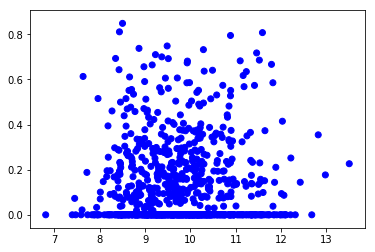

,gene_name,chr,start,end,strand,gene_type,squared_sum,cubed_sum,eta_squared,zscore_squared_sum,zscore_eta_squared,overall_score,color
gene_id,,,,,,,,,,,,,
ENSMUSG00000036192.15,Rorb,chr19,18930605,19111196,-,protein_coding,7.631985,5.767612,0.613239,-2.157443,-2.703313,-2.321204,blue
ENSMUSG00000029705.17,Cux1,chr5,136248135,136567490,-,protein_coding,8.501890,7.318790,0.848492,-1.273503,-4.016385,-2.096367,blue
ENSMUSG00000086220.1,Gm16599,chr5,136274996,136417894,+,antisense_RNA,8.434110,7.182965,0.810903,-1.342376,-3.806582,-2.081638,blue
ENSMUSG00000042589.18,Cux2,chr5,121856366,122050102,-,protein_coding,8.348660,7.080015,0.693031,-1.429205,-3.148676,-1.945046,blue
ENSMUSG00000017978.18,Cadps2,chr6,23262773,23839421,-,protein_coding,7.961621,5.659793,0.515262,-1.822488,-2.156449,-1.922676,blue
ENSMUSG00000083275.1,Gm4993,chrX,120957711,120958884,+,processed_pseudogene,6.807369,4.999641,0.000000,-2.995363,0.719507,-1.880902,blue
ENSMUSG00000045083.14,Lingo2,chr4,35706647,36951747,-,protein_coding,8.425224,6.222293,0.643030,-1.351406,-2.869589,-1.806861,blue
ENSMUSG00000035357.16,Pdzrn3,chr6,101149609,101377897,-,protein_coding,8.865530,7.510946,0.737673,-0.903996,-3.397846,-1.652151,blue
ENSMUSG00000015882.17,Lcorl,chr5,45697181,45857615,-,protein_coding,8.270315,5.944335,0.460235,-1.508814,-1.849315,-1.610964,blue


In [68]:
# organize this bit
# combine squared_sum and eta_squared
marker_rows = 1 - data_pct[(data_pct['2_mcc'] < 0.02)]
markers = df_genes.loc[marker_rows.index, :]
markers = markers.fillna(0)  
# markers = markers.dropna()  # remove genes with missing ANOVA values

### markers rank by measure1 measure2 seperately
# markers['rank_squared_sum'] = markers['squared_sum'].rank(pct=True, axis=0)
# markers['rank_eta_squared'] = markers['eta_squared'].rank(pct=True, axis=0, ascending=False)
# markers['overall_score'] = (0.7*markers['rank_squared_sum'] + 0.3*markers['rank_eta_squared'])
# markers = markers.sort_values('overall_score')

### markers rank by overall zscore
p = 0.7
markers['zscore_squared_sum'] = zscore(markers['squared_sum'].values)
markers['zscore_eta_squared'] = -zscore(markers['eta_squared'].values)
markers['overall_score'] = (p*markers['zscore_squared_sum'] + (1-p)*markers['zscore_eta_squared'])
markers = markers.sort_values('overall_score')

# plot markers on squared_sum and eta_squared
fig, ax = plt.subplots()
markers['color'] = ['black' if gene_name in 'Pvalb' else 'blue' for gene_name in markers['gene_name']]
ax.scatter(markers['squared_sum'].values, markers['eta_squared'].values, c=markers['color'].values)
plt.show()


# for i, (gene_id, gene_row) in enumerate(marker_rows.loc[markers.head(5).index, :].iterrows()):
#     area = np.power(gene_row.sort_values(), 2).sum()
#     plt.plot(gene_row.sort_values().values, label=area)

# c = 1 - data_pct.loc['ENSMUSG00000005716.16', :]
# area = np.power(c, 2).sum()
# plt.plot(c.sort_values().values, label='Pvalb {}'.format(area))
# plt.legend()
# plt.show()
markers.head(30)


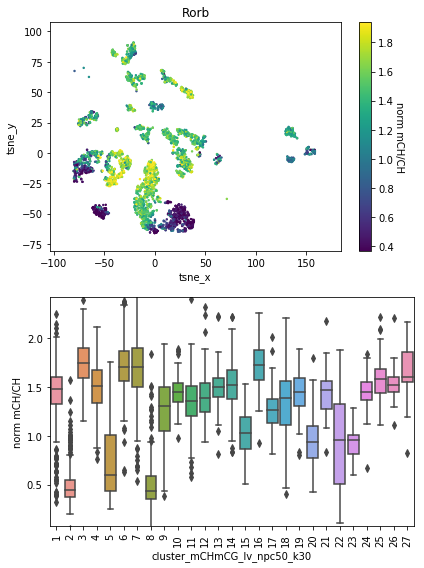

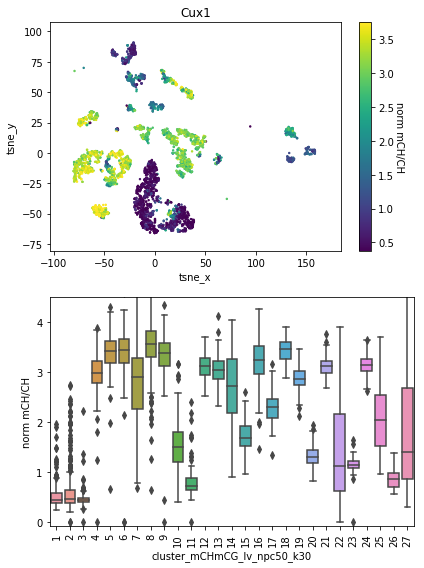

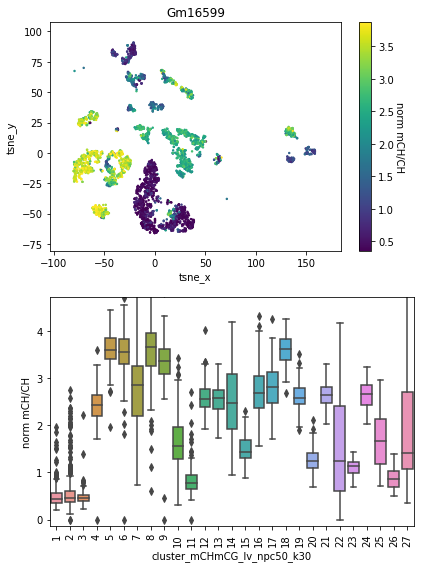

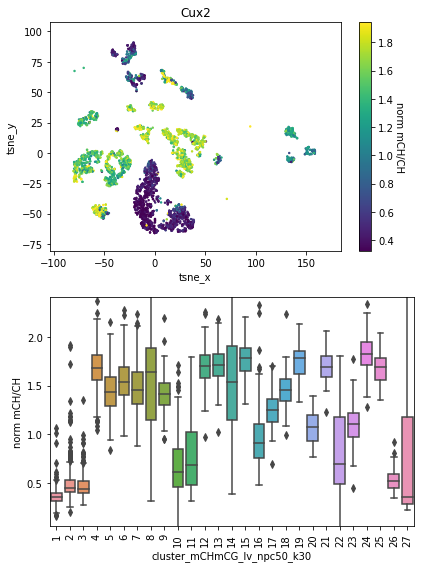

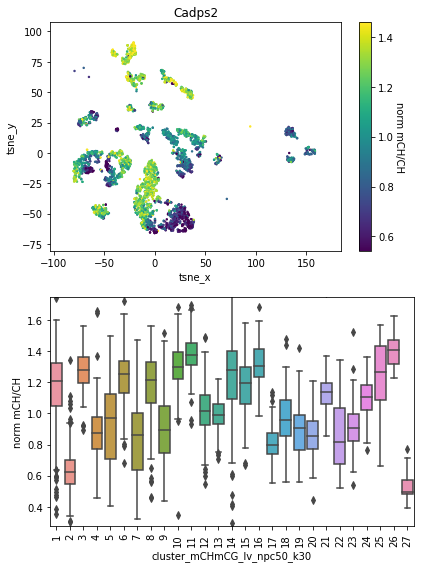

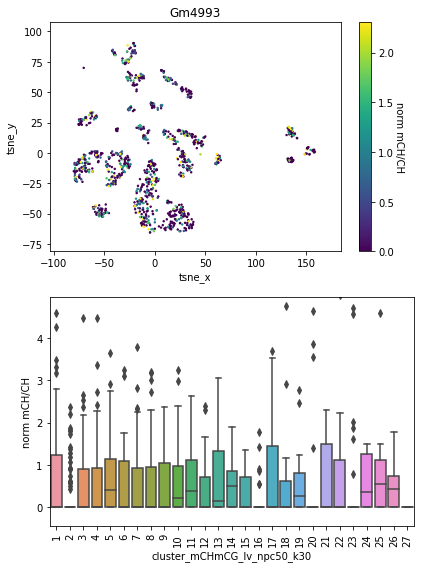

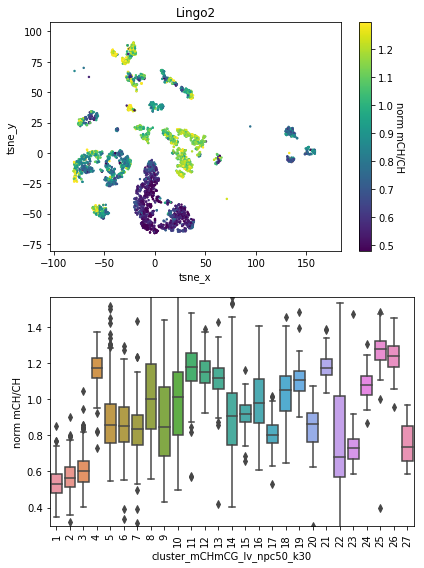

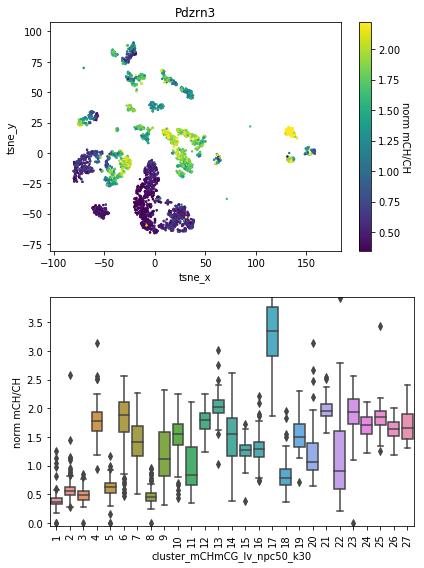

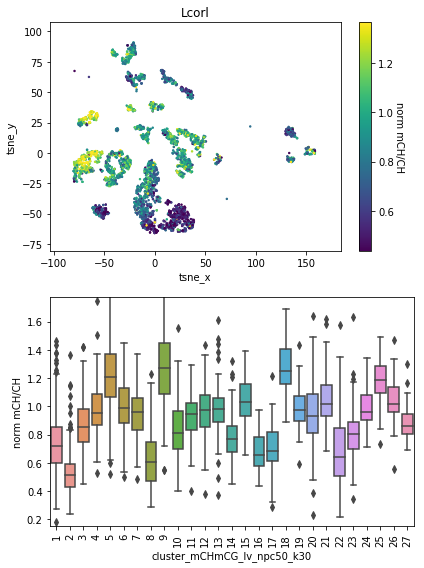

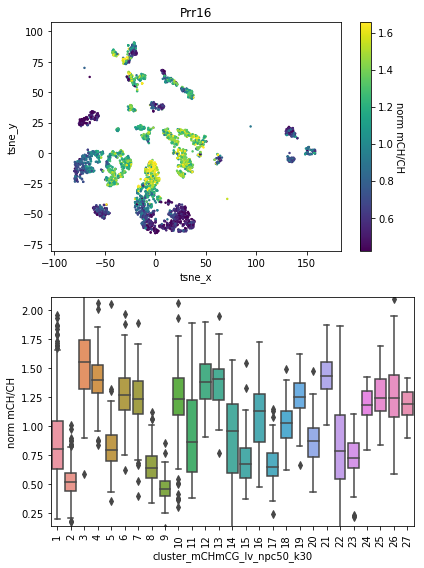

In [69]:
# visualization

engine = connect_sql(DATABASE)

# gene_names = ['Lrrc38', 'Pvalb', 'Erbb4', 'Gad1']
gene_names = markers.head(10)['gene_name'].tolist()
tsne_type = 'mCHmCG_ndim2_perp30'
cluster_type = 'mCHmCG_lv_npc50_k30'

gene_ids = [df_genes[df_genes['gene_name'] == gene_name].index.tolist()[0] for gene_name in gene_names] 
for gene_name, gene_id in zip(gene_names, gene_ids):
    gene_table = gene_id_to_table_name(gene_id) 
    sql = """SELECT tsne_x_{}, tsne_y_{}, cluster_{}, annotation_{}, mCH, CH, global_mCH FROM cells
    JOIN {} ON cells.cell_id = {}.cell_id
    JOIN {} ON cells.cell_id = {}.cell_id""".format(tsne_type, tsne_type, cluster_type, cluster_type, 
                                          ens, ens, 
                                         gene_table, gene_table)
    df_plot = pd.read_sql(sql, engine)
    df_plot['mCH/CH'] = df_plot['mCH']/df_plot['CH']
    df_plot['norm mCH/CH'] = df_plot['mCH/CH']/df_plot['global_mCH']
    tsne_and_boxplot(df_plot, tx='tsne_x_'+tsne_type, ty='tsne_y_'+tsne_type, tc='norm mCH/CH', 
                    bx='cluster_'+cluster_type, by='norm mCH/CH', title=gene_name)
    plt.show()
    
